In [1]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from src.data import raw_io as io
from src.data import conditions as cond

# Load raw data

In [2]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'trials_by_celltype')

In [3]:
def load_sessions_by_day(day: cond.Day):
    sessions = {}
    with h5py.File(os.path.join(DATA_PATH, str(day) + '.h5'), 'r') as f:
        for cell_type in cond.CellType:
            sessions[cell_type] = []
            for mouse in f[cell_type.as_path()].keys():
                sessions[cell_type].append(
                    io.SessionTrials.load(f[cell_type.as_path()][mouse])
                )

        f.close()
    
    return sessions

In [4]:
raw_data_by_day = {
    cond.DAYS[0]: load_sessions_by_day(cond.DAYS[0]), 
    cond.DAYS[-1]: load_sessions_by_day(cond.DAYS[-1])
}

In [5]:
def get_mean_fluorescence_by_cell_type(daily_data):
    mean_fluorescence = {}
    for cell_type in daily_data.keys():

        # Concatenate fluorescence of each mouse
        mean_fluorescence[cell_type] = daily_data[cell_type][0].fluo.trial_mean()
        for i in range(1, len(daily_data[cell_type])):
            trial_mean_fluo = daily_data[cell_type][i].fluo.trial_mean()
            mean_fluorescence[cell_type].append(
                trial_mean_fluo
            )
            del trial_mean_fluo

        print('Got {} {} cells'.format(mean_fluorescence[cell_type].fluo.shape[0], cell_type))
        mean_fluorescence[cell_type].remove_nan()
    
    return mean_fluorescence

In [6]:
mean_fluorescence_by_day = {
    day: get_mean_fluorescence_by_cell_type(raw_data_by_day[day]) 
    for day in raw_data_by_day.keys()
}

Got 1209 pyr cells
Got 189 som cells
Got 252 pv cells
Got 407 vip cells
Got 2098 pyr cells
Got 318 som cells
Got 362 pv cells
Got 565 vip cells


/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:714: UserWarning: Removing 2 all-nan rows
  warnings.warn('Removing {} all-nan rows'.format(np.sum(all_nan_rows)))
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:660: ShapeWarning: `num_frames` in self (428) and other (435) do not match, 7 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:714: UserWarning: Removing 4 all-nan rows
  warnings.warn('Removing {} all-nan rows'.format(np.sum(all_nan_rows)))
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:714: UserWarning: Removing 7 all-nan rows
  warnings.warn('Removing {} all-nan rows'.format(np.sum(all_nan_rows)))
/Users/eharkin/Documents/projects/candice/src/data/raw_io.py:660: ShapeWarning: `num_frames` in self (428) and other (438) do not match, 10 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/eharkin/Documents/projects/candice/src/data/raw_

# Heatmaps

In [7]:
def plot_heatmaps_by_celltype(daily_mean_data):
    for cell_type in cond.CellType:
        print('Clustering mean {} responses'.format(cell_type))
        g = sns.clustermap(mean_fluorescence_by_day[cond.DAYS[0]][cell_type].fluo, col_cluster=False, method='ward')
        g.ax_heatmap.set_xticks(np.linspace(0, mean_fluorescence_by_day[cond.DAYS[0]][cell_type].num_frames, 10))
        g.ax_heatmap.set_xticklabels([
            '{:.1f}'.format(i) for i in
            np.linspace(0, mean_fluorescence_by_day[cond.DAYS[0]][cell_type].duration, 10) - 2.0
        ])
        g.ax_heatmap.set_xlabel('Time from trial start (s)')
        g.ax_heatmap.set_yticks([])
        plt.show()

Clustering mean pyr responses


/miniconda3/envs/candice/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


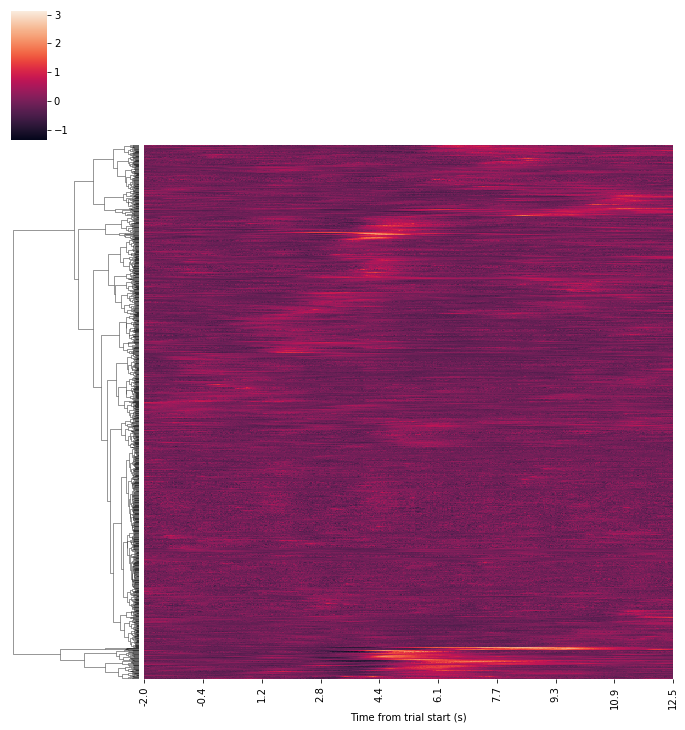

Clustering mean som responses


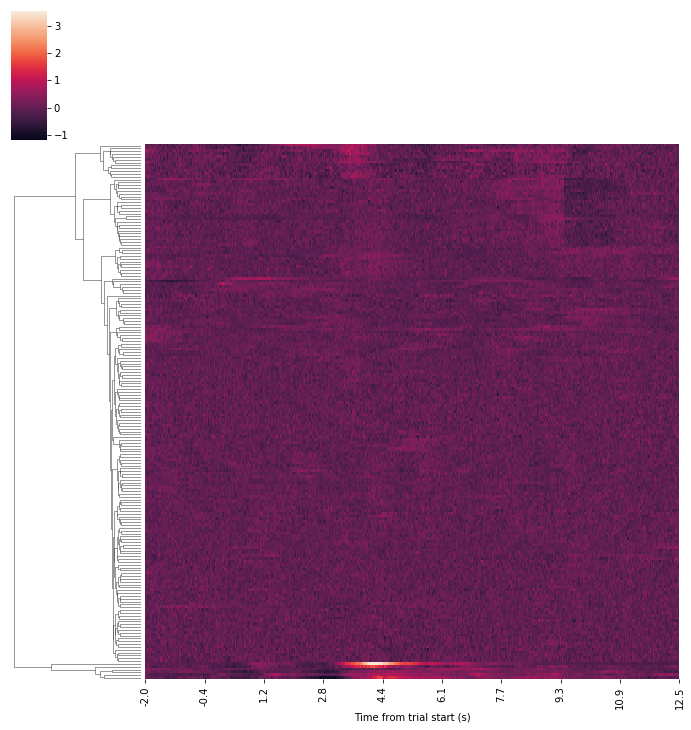

Clustering mean pv responses


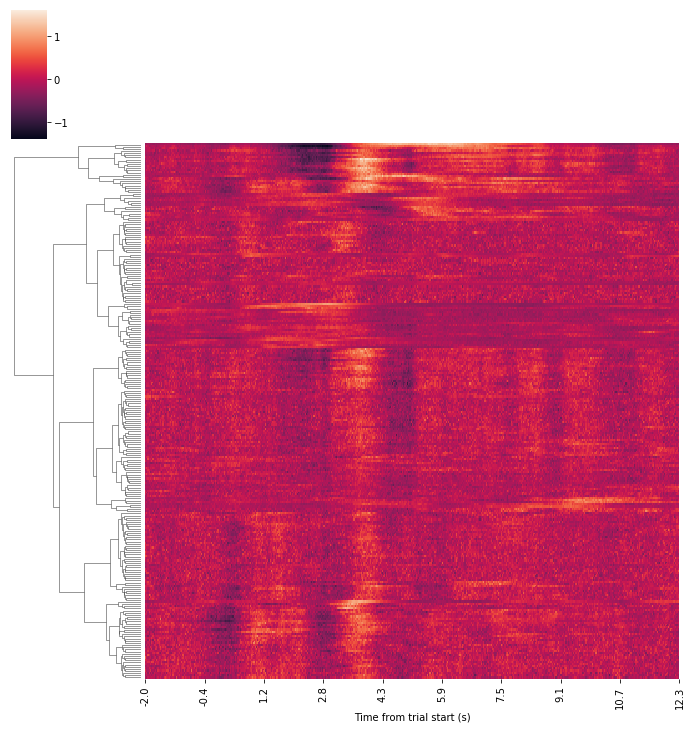

Clustering mean vip responses


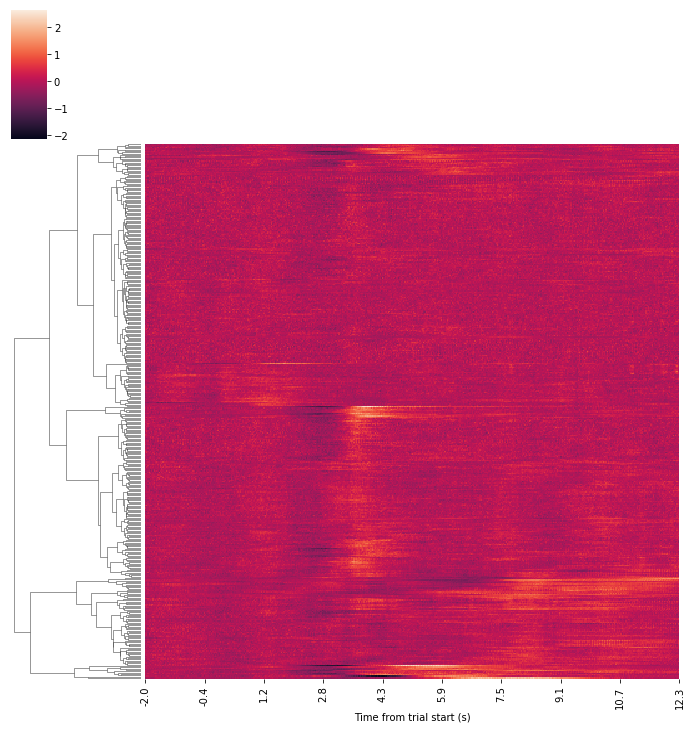

In [8]:
for cell_type in cond.CellType:
    print('Clustering mean {} responses'.format(cell_type))
    g = sns.clustermap(mean_fluorescence_by_day[cond.DAYS[0]][cell_type].fluo, col_cluster=False, method='ward')
    g.ax_heatmap.set_xticks(np.linspace(0, mean_fluorescence_by_day[cond.DAYS[0]][cell_type].num_frames, 10))
    g.ax_heatmap.set_xticklabels([
        '{:.1f}'.format(i) for i in
        np.linspace(0, mean_fluorescence_by_day[cond.DAYS[0]][cell_type].duration, 10) - 2.0
    ])
    g.ax_heatmap.set_xlabel('Time from trial start (s)')
    g.ax_heatmap.set_yticks([])
    plt.show()

# t-SNE

## All cell types together

### First day

In [10]:
labels = []
fluo_matrices = []
for cell_type in cond.CellType:
    labels.extend(
        [
            str(cell_type) for i in 
            range(mean_fluorescence_by_day[cond.DAYS[0]][cell_type].fluo.shape[0])
        ]
    )
    fluo_matrices.append(mean_fluorescence_by_day[cond.DAYS[0]][cell_type].fluo)
    
min_num_frames = np.min([fl.shape[1] for fl in fluo_matrices])
fluo_grand_matrix = np.concatenate([fl[:, :min_num_frames] for fl in fluo_matrices])

In [11]:
tsne = TSNE(perplexity=20, random_state=42, init='pca')
projected = tsne.fit_transform(fluo_grand_matrix)

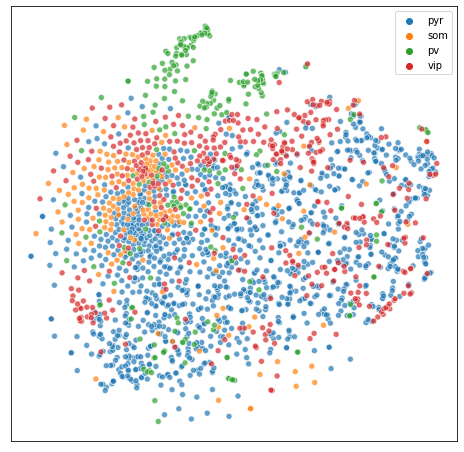

In [12]:
plt.figure(figsize=(8, 8))

plt.subplot(111)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=labels, alpha=0.7)
plt.xticks([])
plt.yticks([])

plt.show()

### Last day

In [13]:
labels = []
fluo_matrices = []
for cell_type in cond.CellType:
    labels.extend(
        [
            str(cell_type) for i in 
            range(mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo.shape[0])
        ]
    )
    fluo_matrices.append(mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo)
    
min_num_frames = np.min([fl.shape[1] for fl in fluo_matrices])
fluo_grand_matrix = np.concatenate([fl[:, :min_num_frames] for fl in fluo_matrices])

In [14]:
tsne = TSNE(perplexity=20, random_state=42, init='pca')
projected = tsne.fit_transform(fluo_grand_matrix)

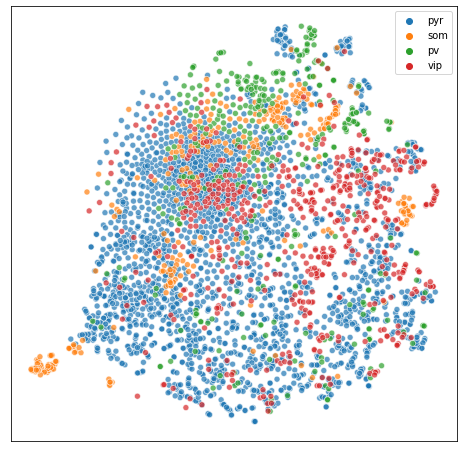

In [15]:
plt.figure(figsize=(8, 8))

plt.subplot(111)
sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=labels, alpha=0.7)
plt.xticks([])
plt.yticks([])

plt.show()

## Each cell type separately

Clustering mean pyr responses


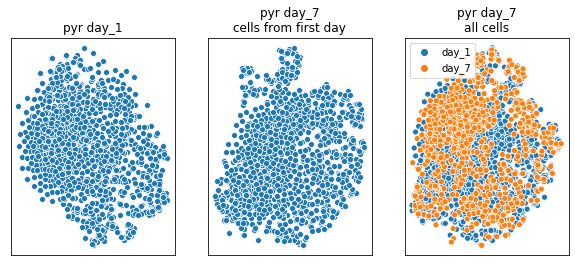

Clustering mean som responses


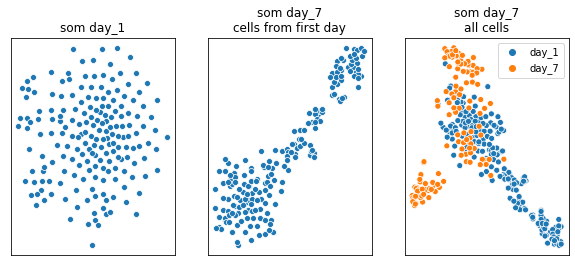

Clustering mean pv responses


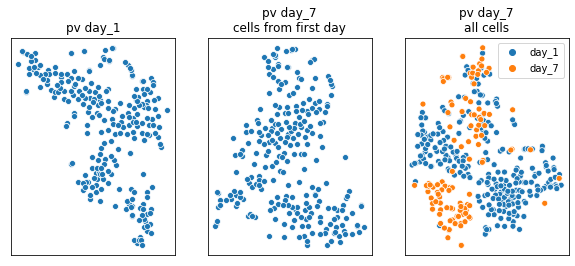

Clustering mean vip responses


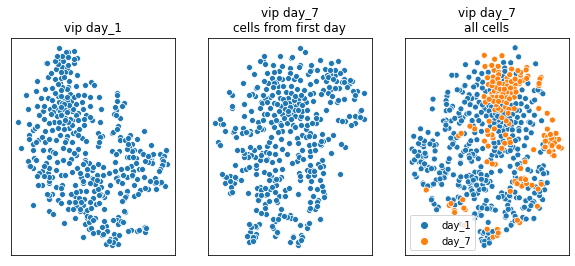

In [16]:
tsne_args = {'perplexity': 20, 'random_state': 43, 'init': 'pca'}

for cell_type in cond.CellType:
    print('Clustering mean {} responses'.format(cell_type))
    
    plt.figure(figsize=(10, 4))
    
    # First day
    plt.subplot(131)
    plt.title(str(cell_type) + ' ' + str(cond.DAYS[0]))

    projected = TSNE(**tsne_args).fit_transform(mean_fluorescence_by_day[cond.DAYS[0]][cell_type].fluo)
    sns.scatterplot(projected[:, 0], projected[:, 1])
    plt.xticks([])
    plt.xlabel('')
    plt.yticks([])
    plt.ylabel('')
    
    # Last day, only cells from first day
    plt.subplot(132)
    plt.title(str(cell_type) + ' ' + str(cond.DAYS[-1]) + '\ncells from first day')
    
    num_first_day_cells = mean_fluorescence_by_day[cond.DAYS[0]][cell_type].fluo.shape[0]
    projected = TSNE(**tsne_args).fit_transform(
        mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo[:num_first_day_cells, :]
    )
    sns.scatterplot(projected[:, 0], projected[:, 1])
    plt.xticks([])
    plt.xlabel('')
    plt.yticks([])
    plt.ylabel('')
    
    # Last day, all cells
    plt.subplot(133)
    plt.title(str(cell_type) + ' ' + str(cond.DAYS[-1]) + '\nall cells')
    
    projected = TSNE(**tsne_args).fit_transform(mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo)
    cells_from_day = [cond.DAYS[0] for i in range(num_first_day_cells)]
    cells_from_day.extend([cond.DAYS[-1] for i in range(
        mean_fluorescence_by_day[cond.DAYS[-1]][cell_type].fluo.shape[0] - num_first_day_cells
    )])
    sns.scatterplot(projected[:, 0], projected[:, 1], hue=cells_from_day)
    plt.xticks([])
    plt.xlabel('')
    plt.yticks([])
    plt.ylabel('')
    
    plt.show()